# YOLO - YOLO Generate Pseudo-Labels

# Import

In [1]:
import torch
from ultralytics import YOLO
from IPython.display import display, Image
import time
import os
import cv2
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random
from PIL import Image



In [2]:
torch.cuda.is_available()

True

# Choose Model and mode

In [3]:
model = YOLO('Model/ood_1.pt')
Statics = True
# conf_thershold = 0.93

# Running the model & Genrating Labels

In [4]:
# results_video1 = model.predict(source='data/id_video_data/20_2_24_1.mp4',
#                                save=True, stream=True, vid_stride=10, save_txt=True,
#                                save_conf=True, save_frames=True, show_labels=False,
#                                show_conf=False, show_boxes=False)

# results_video2 = model.predict(source='data/id_video_data/4_2_24_B_2.mp4',
#                                save=True, stream=True, vid_stride=10, save_txt=True,
#                                save_conf=True, save_frames=True, show_labels=False,
#                                show_conf=False, show_boxes=False)
results_video1 = model.predict(source='data/ood_video_data/4_2_24_A_1.mp4',
                               save=True, stream=True, vid_stride=3, save_txt=True,
                               save_conf=True, save_frames=True, show_labels=False,
                               show_conf=False, show_boxes=False)

In [5]:
for result in results_video1:
    boxes = result.boxes  # Boxes object for bounding box outputs
# for result in results_video2:
#     boxes = result.boxes  # Boxes object for bounding box outputs


video 1/1 (frame 1/1798) D:\Tomer\TASP\Semester_2\Computer Vision in Surgical Applications\HW1\data\ood_video_data\4_2_24_A_1.mp4: 384x640 1 Tweezers, 1 Needle_driver, 20.9ms
video 1/1 (frame 2/1798) D:\Tomer\TASP\Semester_2\Computer Vision in Surgical Applications\HW1\data\ood_video_data\4_2_24_A_1.mp4: 384x640 1 Tweezers, 1 Needle_driver, 16.0ms
video 1/1 (frame 3/1798) D:\Tomer\TASP\Semester_2\Computer Vision in Surgical Applications\HW1\data\ood_video_data\4_2_24_A_1.mp4: 384x640 1 Tweezers, 1 Needle_driver, 14.0ms
video 1/1 (frame 4/1798) D:\Tomer\TASP\Semester_2\Computer Vision in Surgical Applications\HW1\data\ood_video_data\4_2_24_A_1.mp4: 384x640 2 Needle_drivers, 10.0ms
video 1/1 (frame 5/1798) D:\Tomer\TASP\Semester_2\Computer Vision in Surgical Applications\HW1\data\ood_video_data\4_2_24_A_1.mp4: 384x640 1 Needle_driver, 15.0ms
video 1/1 (frame 6/1798) D:\Tomer\TASP\Semester_2\Computer Vision in Surgical Applications\HW1\data\ood_video_data\4_2_24_A_1.mp4: 384x640 1 Needle

**Saving all labels**

# Confidence Statistics

In [19]:
if Statics:
    # Directory containing the pseudo-label files
    pseudo_labels_dir = 'runs/detect/predict/labels'
    
    # Function to calculate statistics from pseudo-label files
    def calculate_statistics_and_collect_confidences(pseudo_labels_dir):
        confidence_dict = defaultdict(list)
        
        for label_file in os.listdir(pseudo_labels_dir):
            label_path = os.path.join(pseudo_labels_dir, label_file)
            
            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.strip().split()
                    cls = int(parts[0])  # Class label
                    conf = float(parts[5])  # Confidence score
                    confidence_dict[cls].append(conf)
        
        # Calculate statistics for each label
        statistics = {}
        for cls, confidences in confidence_dict.items():
            confidences_np = np.array(confidences)
            statistics[cls] = {
                'mean_confidence': np.mean(confidences_np),
                'std_confidence': np.std(confidences_np),
                'min_confidence': np.min(confidences_np),
                'max_confidence': np.max(confidences_np),
                'confidences': confidences_np  # Store confidences for histogram
            }
        
        return statistics
    
    # Calculate statistics and collect confidence levels
    statistics = calculate_statistics_and_collect_confidences(pseudo_labels_dir)
    
    # Print statistics
    for cls, stats in statistics.items():
        print(f"Class {cls}:")
        print(f"  Mean Confidence: {stats['mean_confidence']:.4f}")
        print(f"  Standard Deviation: {stats['std_confidence']:.4f}")
        print(f"  Min Confidence: {stats['min_confidence']:.4f}")
        print(f"  Max Confidence: {stats['max_confidence']:.4f}")


Class 1:
  Mean Confidence: 0.8982
  Standard Deviation: 0.1204
  Min Confidence: 0.2519
  Max Confidence: 0.9845
Class 2:
  Mean Confidence: 0.8368
  Standard Deviation: 0.1329
  Min Confidence: 0.2501
  Max Confidence: 0.9872
Class 0:
  Mean Confidence: 0.7900
  Standard Deviation: 0.1977
  Min Confidence: 0.2505
  Max Confidence: 0.9944


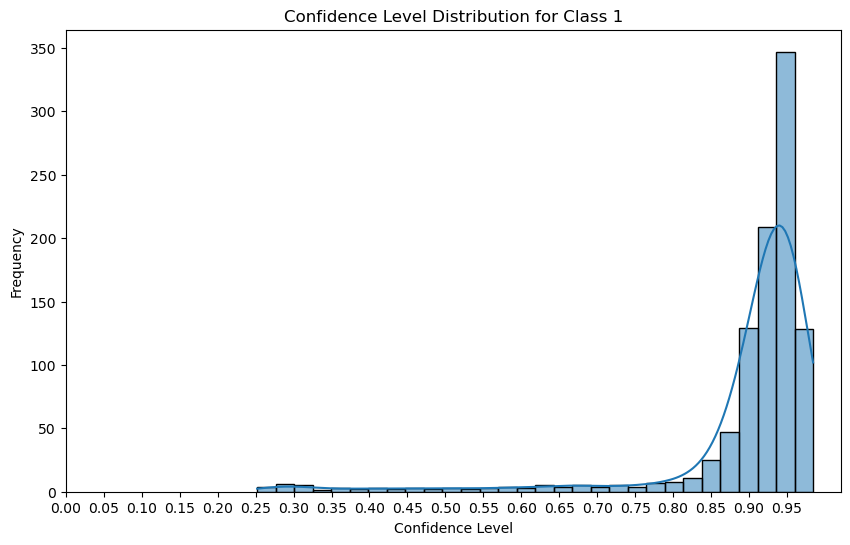

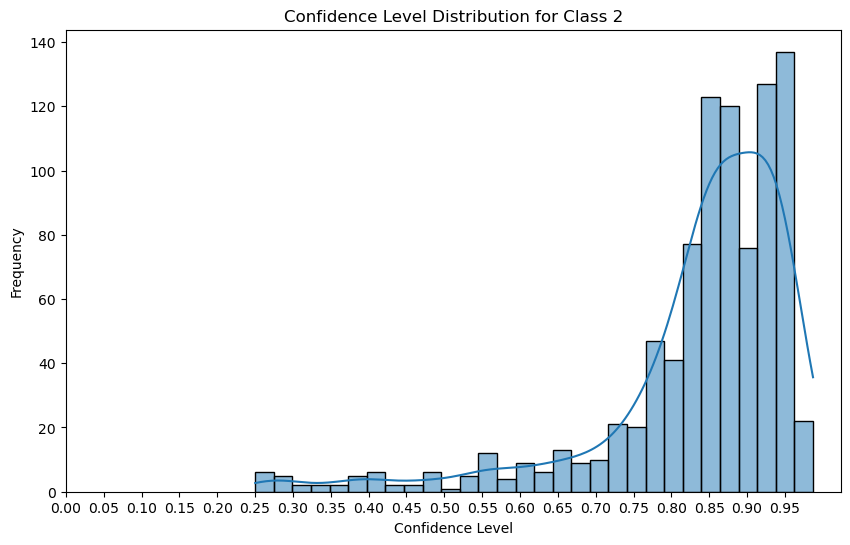

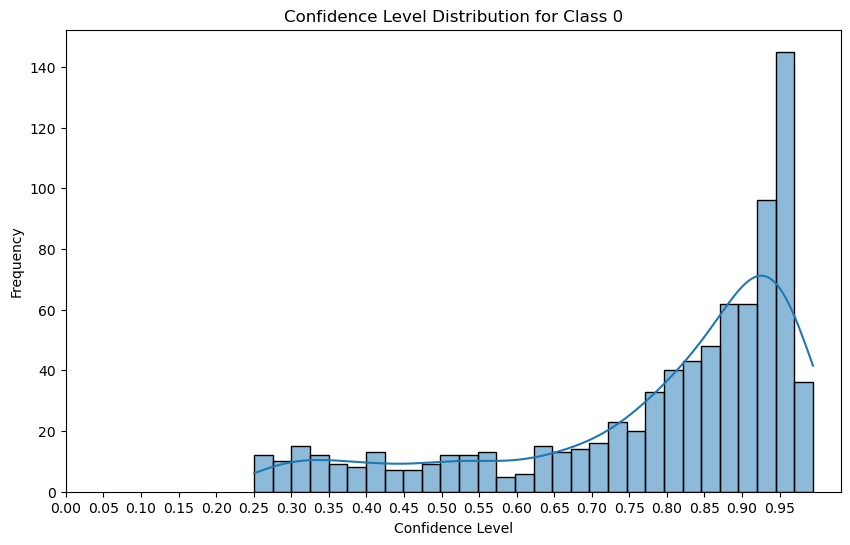

In [20]:
if Statics:
    # Plot histograms of confidence levels
    for cls, stats in statistics.items():
        plt.figure(figsize=(10, 6))
        sns.histplot(stats['confidences'], bins=30, kde=True)
        plt.title(f'Confidence Level Distribution for Class {cls}')
        plt.xlabel('Confidence Level')
        plt.ylabel('Frequency')
        # Customize x-axis ticks
        plt.xticks(np.arange(0, 1, 0.05))  # Adjust step as needed
        plt.show()

In [14]:
if Statics:
    def count_instances_above_threshold(statistics, confidence_threshold):
        counts_above_threshold = {}
        total_counts = {}
    
        for cls, stats in statistics.items():
            confidences = stats['confidences']
            total_count = len(confidences)
            count_above_threshold = np.sum(confidences >= confidence_threshold)
            
            counts_above_threshold[cls] = {
                'count_above_threshold': count_above_threshold,
                'total_count': total_count,
                'percentage_above_threshold': (count_above_threshold / total_count) * 100 if total_count > 0 else 0
            }
        
        return counts_above_threshold
    
    # Example usage:
    confidence_threshold = 0.95  # Set your desired confidence threshold here
    counts_above_threshold = count_instances_above_threshold(statistics, confidence_threshold)
    
    # Print the counts and percentages
    for cls, stats in counts_above_threshold.items():
        print(f"Class {cls}:")
        print(f"  Total instances: {stats['total_count']}")
        print(f"  Instances above confidence threshold of {confidence_threshold}: {stats['count_above_threshold']}")
        print(f"  Percentage above threshold: {stats['percentage_above_threshold']:.2f}%")

Class 2:
  Total instances: 1719
  Instances above confidence threshold of 0.95: 203
  Percentage above threshold: 11.81%
Class 1:
  Total instances: 1069
  Instances above confidence threshold of 0.95: 184
  Percentage above threshold: 17.21%
Class 0:
  Total instances: 270
  Instances above confidence threshold of 0.95: 39
  Percentage above threshold: 14.44%


# Rename, Split, Shuffle and delete below conf

In [15]:
def rename_files_in_directory(directory, prefix='', suffix=''):
    """
    Rename multiple files in a directory by appending a prefix or suffix to their original names.

    :param directory: The directory containing the files to rename.
    :param prefix: The prefix to add to the original filenames.
    :param suffix: The suffix to add to the original filenames.
    """
    for filename in os.listdir(directory):
        # Construct the old and new file paths
        old_filepath = os.path.join(directory, filename)
        
        # Skip directories
        if os.path.isdir(old_filepath):
            continue
        
        # Extract the file name and extension
        file_name, file_extension = os.path.splitext(filename)
        
        # Construct the new file name
        new_filename = f"{prefix}{file_name}{suffix}{file_extension}"
        new_filepath = os.path.join(directory, new_filename)
        
        # Rename the file
        os.rename(old_filepath, new_filepath)
        print(f"Renamed: {old_filepath} -> {new_filepath}")

# Execute
directory_path = 'runs/detect/predict/4_2_24_A_1_frames'
prefix = '4_2_24_A_1_'
suffix = ''
rename_files_in_directory(directory_path, prefix, suffix)

# directory_path = 'runs/detect/predict/4_2_24_B_2_frames'
# prefix = '4_2_24_B_2_'
# suffix = ''
# rename_files_in_directory(directory_path, prefix, suffix)


Renamed: runs/detect/predict/4_2_24_A_1_frames\1.jpg -> runs/detect/predict/4_2_24_A_1_frames\4_2_24_A_1_1.jpg
Renamed: runs/detect/predict/4_2_24_A_1_frames\10.jpg -> runs/detect/predict/4_2_24_A_1_frames\4_2_24_A_1_10.jpg
Renamed: runs/detect/predict/4_2_24_A_1_frames\100.jpg -> runs/detect/predict/4_2_24_A_1_frames\4_2_24_A_1_100.jpg
Renamed: runs/detect/predict/4_2_24_A_1_frames\1000.jpg -> runs/detect/predict/4_2_24_A_1_frames\4_2_24_A_1_1000.jpg
Renamed: runs/detect/predict/4_2_24_A_1_frames\1001.jpg -> runs/detect/predict/4_2_24_A_1_frames\4_2_24_A_1_1001.jpg
Renamed: runs/detect/predict/4_2_24_A_1_frames\1002.jpg -> runs/detect/predict/4_2_24_A_1_frames\4_2_24_A_1_1002.jpg
Renamed: runs/detect/predict/4_2_24_A_1_frames\1003.jpg -> runs/detect/predict/4_2_24_A_1_frames\4_2_24_A_1_1003.jpg
Renamed: runs/detect/predict/4_2_24_A_1_frames\1004.jpg -> runs/detect/predict/4_2_24_A_1_frames\4_2_24_A_1_1004.jpg
Renamed: runs/detect/predict/4_2_24_A_1_frames\1005.jpg -> runs/detect/predi

**Filter Labels and image below conf or with double recogniation**

In [16]:
def filter_labels_and_images(labels_dir, images_dir, confidence_threshold):
    """
    Filters out labels and corresponding images that have confidence levels below a threshold
    or if the same label appears multiple times in an image.
    
    :param labels_dir: Directory containing YOLO annotation files.
    :param images_dir: Directory containing images.
    :param confidence_threshold: Confidence level threshold.
    """
    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            label_path = os.path.join(labels_dir, label_file)
            image_file = label_file.replace('.txt', '.jpg')  # Assuming images are in .jpg format
            image_path = os.path.join(images_dir, image_file)
            
            with open(label_path, 'r') as file:
                lines = file.readlines()

            keep_file = True
            label_counts = {}

            for line in lines:
                parts = line.strip().split()
                if len(parts) == 6:  # If there is a confidence level in the label file
                    confidence = float(parts[5])
                    if confidence < confidence_threshold:
                        keep_file = False
                        break
                
                label = parts[0]
                if label in label_counts:
                    label_counts[label] += 1
                else:
                    label_counts[label] = 1
                
                if label_counts[label] > 1:
                    keep_file = False
                    break
            
            if not keep_file:
                os.remove(label_path)
                if os.path.exists(image_path):
                    os.remove(image_path)

def remove_confidence_levels(labels_dir):
    """
    Removes confidence levels from YOLO annotation files.
    
    :param labels_dir: Directory containing YOLO annotation files.
    """
    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            label_path = os.path.join(labels_dir, label_file)
            
            with open(label_path, 'r') as file:
                lines = file.readlines()
            
            with open(label_path, 'w') as file:
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) == 6:  # If there is a confidence level in the label file
                        parts = parts[:5]  # Remove the confidence level
                    file.write(' '.join(parts) + '\n')

def main(labels_dir, images_dir, confidence_threshold):
    # Step 1: Filter labels and images based on confidence threshold and duplicate labels
    filter_labels_and_images(labels_dir, images_dir, confidence_threshold)
    
    # Step 2: Remove confidence levels from remaining labels
    remove_confidence_levels(labels_dir)

# Example usage
labels_dir = 'runs/detect/predict/labels'
images_dir = 'runs/detect/predict/images'
confidence_threshold = 0.95  # Set your confidence threshold here

main(labels_dir, images_dir, confidence_threshold)

In [17]:
def split_data(image_dir, label_dir, output_dir, val_split_percentage=0.2):
    # Ensure output directories exist
    train_images_dir = os.path.join(output_dir, 'images/train')
    val_images_dir = os.path.join(output_dir, 'images/val')
    train_labels_dir = os.path.join(output_dir, 'labels/train')
    val_labels_dir = os.path.join(output_dir, 'labels/val')
    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(val_images_dir, exist_ok=True)
    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(val_labels_dir, exist_ok=True)

    # Get list of files in the images directory
    image_files = os.listdir(image_dir)
    label_files = os.listdir(label_dir)

    # # Ensure each image has a corresponding label
    base_names = set(os.path.splitext(f)[0] for f in image_files)
    # if base_names != set(os.path.splitext(f)[0] for f in label_files):
    #     raise ValueError("Mismatch between images and labels")

    # Shuffle the base names
    base_names = list(base_names)
    random.shuffle(base_names)

    # Determine split index
    split_idx = int(len(base_names) * val_split_percentage)

    # Create training and validation sets
    val_names = base_names[:split_idx]
    train_names = base_names[split_idx:]

    def move_files(names, src_img_dir, src_lbl_dir, dst_img_dir, dst_lbl_dir):
        for name in names:
            image_file = name + '.jpg'
            label_file = name + '.txt'
            # Move label
            if os.path.exists(os.path.join(src_lbl_dir, label_file)):
                shutil.copy(os.path.join(src_lbl_dir, label_file), os.path.join(dst_lbl_dir, label_file))
            else:
                continue
            # Move image
            if os.path.exists(os.path.join(src_img_dir, image_file)):
                shutil.copy(os.path.join(src_img_dir, image_file), os.path.join(dst_img_dir, image_file))
            else:
                print(f"Image not found: {image_file}")


    # Move files to respective directories
    move_files(train_names, image_dir, label_dir, train_images_dir, train_labels_dir)
    move_files(val_names, image_dir, label_dir, val_images_dir, val_labels_dir)

# Example usage
image_dir = 'runs/detect/predict/images'
label_dir = 'runs/detect/predict/labels'
output_dir = 'runs/detect/predict/ood_1'
split_data(image_dir, label_dir, output_dir, val_split_percentage=0.2)